# **Predicting Wine Class Using KNN Classifier Algorithm**


## **Introduction**

Our topic is centered around the composition of wine. The dataset we are using collected results of “chemical analysis” of wine grown by different people within a singular region in Italy. In this dataset, there are 13 different columns, which are variables indicating the different measures of composition of wine. Namely, these variables are Alcohol, Malic Acid, Ash, Alkalinity of ash, Magnesium, Total Phenols, Flavonoids, Non-Flavonoid Phenols, Proanthocyanidins, Color intensity, Hue, OD280/OD315 of diluted wines and Proline. There are three different types of wine classes observed in this dataset, and they have been numbered 1,2 or 3 under the column “Class”. The predictive question we will aim to answer is: Given a composition of wine, predict which class, from the 3 possible ones in this dataset, that particular wine belongs to. There are no missing values for any of the variables in this dataset.



## **Preliminary exploratory data analysis**

In [16]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

In [17]:
wine_data <- read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", col_names = FALSE) |>
    mutate(X1 = as_factor(X1))
colnames(wine_data) <- c("class","alcohol", "malic.acid", "ash", "alcalinity.of.ash","magnesium", "total.phenols",
                         "flavanoids", "nonfalvanoid.phenols", "proanthocyanins", "color.intensity", "hue",
                         "OD280.OD315.of.diluted.wines", "proline")
wine_data

wine_split <- initial_split(wine_data, prop = 0.75, strata = class)  
wine_training <- training(wine_split)   
wine_testing <- testing(wine_split)

Rows: 178 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (14): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X12, X13, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


class,alcohol,malic.acid,ash,alcalinity.of.ash,magnesium,total.phenols,flavanoids,nonfalvanoid.phenols,proanthocyanins,color.intensity,hue,OD280.OD315.of.diluted.wines,proline
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.2,0.59,1.56,835
3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.3,0.60,1.62,840
3,14.13,4.10,2.74,24.5,96,2.05,0.76,0.56,1.35,9.2,0.61,1.60,560


In [18]:
wine_mean <- wine_training |>
    summarise(across(alcohol:proline, mean)) |>
    pivot_longer(cols = alcohol:proline,
                 names_to = 'attribute',
                 values_to = 'mean') 
wine_min <- wine_training |>
    summarise(across(alcohol:proline, min)) |>
    pivot_longer(cols = alcohol:proline,
                 names_to = 'attribute',
                 values_to = 'min') 
wine_max <- wine_training |>
    summarise(across(alcohol:proline, max)) |>
    pivot_longer(cols = alcohol:proline,
                 names_to = 'attribute',
                 values_to = 'max') 
wine_sd <- wine_training |>
    summarise(across(alcohol:proline, sd)) |>
    pivot_longer(cols = alcohol:proline,
                 names_to = 'attribute',
                 values_to = 'sd') 

wine_stats <- wine_min |>
    bind_cols(wine_max |> select(max)) |>
    bind_cols(wine_mean |> select(mean)) |>
    bind_cols(wine_sd |> select(sd))

wine_stats

wine_proportions <- wine_training |>
    group_by(class) |>
    summarize(n = n())
wine_proportions

attribute,min,max,mean,sd
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
alcohol,11.03,14.83,13.011880,0.8048651
malic.acid,0.74,5.80,2.327218,1.1451739
ash,1.36,3.22,2.359549,0.2781238
⋮,⋮,⋮,⋮,⋮
hue,0.48,1.71,0.9606466,0.2311477
OD280.OD315.of.diluted.wines,1.27,4.00,2.5954135,0.7112851
proline,278.00,1680.00,754.8421053,317.1756478


class,n
<fct>,<int>
1,44
2,53
3,36


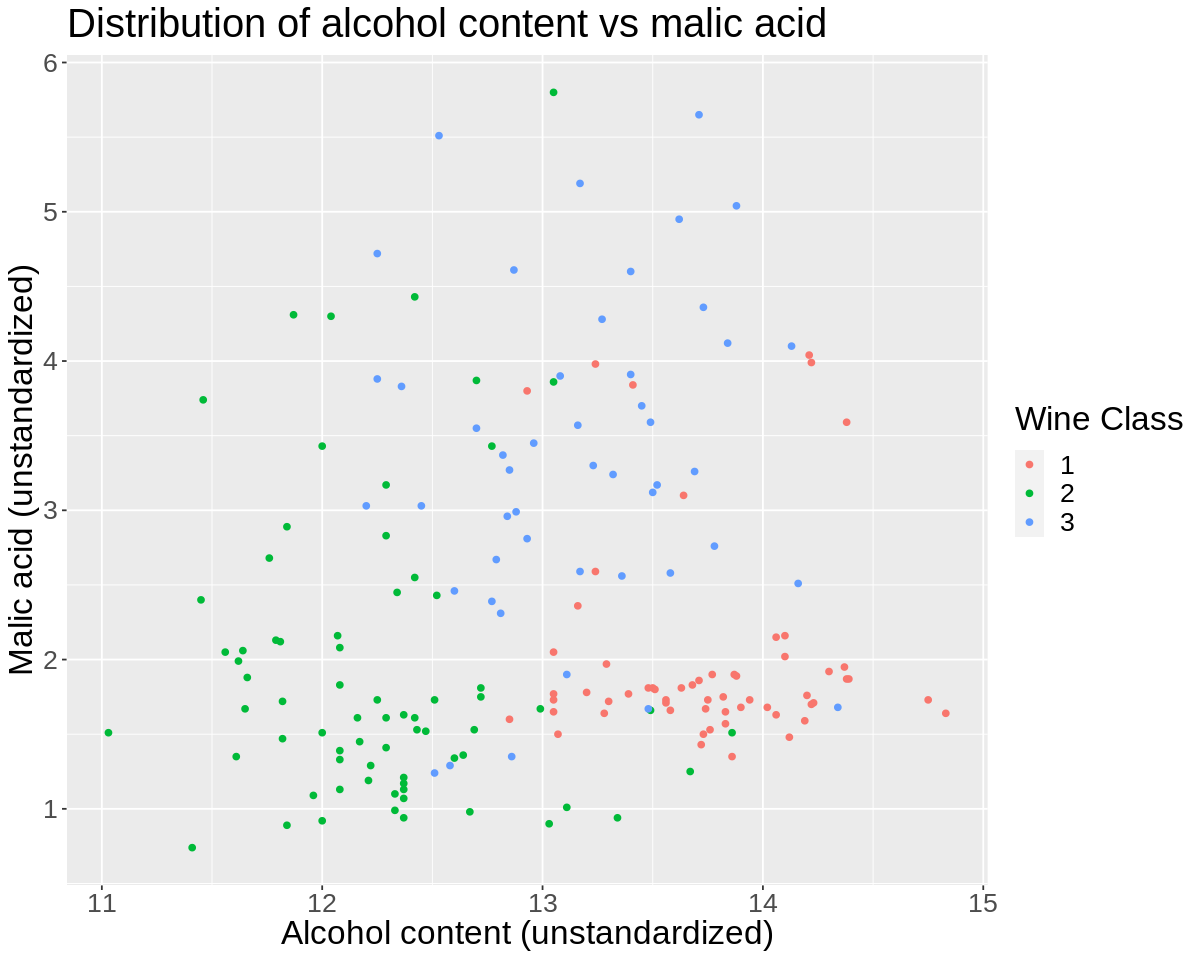

In [19]:
options(repr.plot.width = 10, repr.plot.height = 8)
wine_plot <- wine_data |>
    ggplot(aes(x = alcohol, y = malic.acid, colour = class)) +
    geom_point() +
    labs(x = "Alcohol content (unstandardized)", y = "Malic acid (unstandardized)", colour = "Wine Class") +
    theme(text = element_text(size = 20)) +
    ggtitle("Distribution of alcohol content vs malic acid")
wine_plot

## **Methods**

### Preprocessing the dataset
We will use step_center() and step_scale() to standardize our predictor variables. 
In our dataset, we see that the values in our proline column are higher than the rest.
This is because the computation of nearest neighbors is dominated by the much larger-scale area variable.

### Balancing the dataset
We will take care of balancing the dataset. Since we do not have NA values in the dataset, we will not run into the problem of dataset imbalance. We will split the wine dataset by splitting the training data, training on one subset, and evaluating on the other.

### Selecting the best-predictors
Currently, we are trying to figure out how many predictors we are going to use for this dataset. We will follow the prediction selection algorithm given in the textbook. Doing this will get a better estimate of accuracy, which will lead to a better choice of the number of neighbors K.

### Selecting the best K-value to use in KNN
We can achieve this by plotting the accuracy versus K using the ggplot function.

### Test for Overfitting and Underfitting
We can check if we are overfitting the dataset by plotting accuracy vs neighbors we use the dataset. As the accuracy starts to fall, that is the point that we know we are overfitting. We will choose a k value that gives us the highest accuracy but that is neither too small (which will lead to overfitting) or too high (which will lead to underfitting).

### Evaluating on the test-dataset
The confusion matrix table will show us how many predictions were correctly predicted and how many predictions were wrongly predicted.
We can also use the accuracy from tidymodels to calculate the prediction score.







## **Expected outcomes and significance**

We expect to find wines with an appropriately chosen chemical composition will fall under one of these classes of wine. Such findings could help wine companies to manufacture different classes of wine. Future questions could be to determine which class of wine is the easiest to make based on composition.   

